In [1]:
from utils_project import * 

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial n=579
Validation n=255
Combined n=834
Questionnaire items loaded


# Date completed

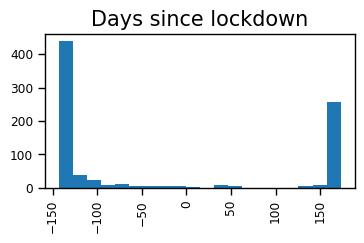

In [33]:
# get columns that have date in their name
date_data = data['date']
date_data = pd.to_datetime(date_data, format='%Y-%m-%d')

# get days since lockdown for date_data, put in data
data['days_since_lockdown_start'] = (date_data - pd.to_datetime('2020-03-15')).dt.days
data['days_since_vaccine_fda']    = (date_data - pd.to_datetime('2021-8-23')).dt.days # approval


# plot date_data in histplot
plt.figure(figsize=(4,2))
plt.hist(data['days_since_vaccine_fda'], bins=20)
plt.xticks(rotation=90)
plt.title('Days since lockdown')
plt.show()

# Summarize demographics for both samples

In [5]:
demos_df = pd.DataFrame()

for s in [0, 1]:
    sample_data = data[data['sample']==s]
    n = len(sample_data)

    demos_df.loc[s, 'n'] = n

    # age
    demos_df.loc[s, 'age_M'] = np.mean(sample_data['demo_age'])
    demos_df.loc[s, 'age_SD'] = np.std(sample_data['demo_age'])

    # sex
    sex_demo = sample_data['demo_sex_1F'].value_counts()
    for sex, sex_int in {'F': 1, 'M': 2, 'other': 3}.items():
        demos_df.loc[s, f'sex_{sex}'] = sex_demo[sex_demo.index==sex_int].values[0] 
        demos_df.loc[s, f'sex_{sex}%'] = (sex_demo[sex_demo.index==sex_int].values[0] / n) * 100

    # gender 
    # gender_demo = sample_data['demo_gender_1W'].value_counts()
    # for gender, gender_int in {'W': 1, 'M': 2, 'nb': 3, 'other': 4}.items():
    #     demos_df.loc[s, f'gender_{gender}'] = gender_demo[gender_demo.index==gender_int].values[0] 
    #     demos_df.loc[s, f'gender_{gender}%'] = (gender_demo[gender_demo.index==gender_int].values[0] / n) * 100   

    # race: white, black, asian, native, other
    # ethnicity: hispanic, non-hispanic
    race_cols = [c for c in sample_data.columns if ('demo_race' in c) & ('text' not in c) & ('latino' not in c)]
    race_demo = np.sum(sample_data[race_cols], axis=0)
    for race_col in race_cols:
        race = ('_').join(race_col.split('_')[2:])
        demos_df.loc[s, f'{race}%'] = (race_demo[race_col] / n) * 100
    
    n_hisp = np.sum(sample_data[[c for c in sample_data.columns if ('latino' in c)]].values, axis=0)
    demos_df.loc[s, 'hispanic%'] = (n_hisp / n) * 100
    demos_df.loc[s, 'non_hispanic%'] = ((n - n_hisp) / n) * 100

    # perceived social status
    demos_df.loc[s, 'ladder_M'] = np.mean(sample_data['demo_ladder_rate'], axis=0)
    demos_df.loc[s, 'ladder_SD'] = np.std(sample_data['demo_ladder_rate'], axis=0)

    # psych. disorders
    demos_df.loc[s, 'diagnosed_6months%'] = (np.sum(sample_data['demo_diag_6mo'].values) / n) * 100

    n_disorders = np.sum(sample_data[['demo_adjust','demo_adhd','demo_autism','demo_bipolar','demo_avpd',
                                     'demo_bpd','demo_mdd','demo_ed','demo_gad','demo_ocd','demo_ld',
                                     'demo_panic','demo_gambling','demo_ptsd','demo_scz','demo_spd','demo_sad',
                                     'demo_tourettes','demo_sud','demo_other_disorder']], axis=0)
    disorder_strs = [('_').join(c.split('_')[1:]) for c in n_disorders.index]
    demos_df.loc[s, disorder_strs] = n_disorders.values
    demos_df.loc[s, [f'{d}%' for d in disorder_strs]] = (n_disorders.values / n) * 100
  
demos_df.index=['initial', 'validation']
demos_df.to_excel(f'{base_dir}/Data/Demo-summaries.xlsx', index=False)
display(demos_df)

,n,age_M,age_SD,sex_F,sex_F%,sex_M,sex_M%,sex_other,sex_other%,amer_indian_or_alaska_native%,...,ld%,panic%,gambling%,ptsd%,scz%,spd%,sad%,tourettes%,sud%,other_disorder%
initial,579.0,38.4301,13.3706,288.0,49.7409,290.0,50.0864,1.0,0.1727,2.2453,...,0.0000,0.6908,0.0,1.0363,0.0,0.0,0.6908,0.0,0.1727,0.0
validation,255.0,33.1725,10.5997,148.0,58.0392,106.0,41.5686,1.0,0.3922,0.7843,...,0.3922,1.1765,0.0,1.1765,0.0,0.0,1.5686,0.0,0.3922,0.0


# Psychiatric function

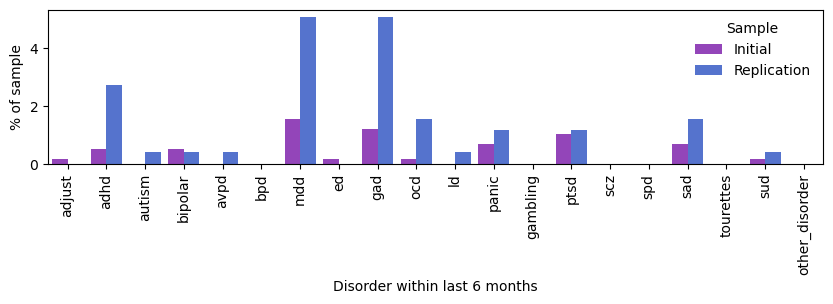

In [40]:
def percent(X):
    return np.mean(X, axis=0) * 100

disorders = data[['sample','demo_adjust','demo_adhd','demo_autism','demo_bipolar','demo_avpd',
                  'demo_bpd','demo_mdd','demo_ed','demo_gad','demo_ocd','demo_ld',
                  'demo_panic','demo_gambling','demo_ptsd','demo_scz','demo_spd','demo_sad',
                  'demo_tourettes','demo_sud','demo_other_disorder']].fillna(0)

data['disorder'] = (np.sum(disorders.iloc[:,1:], axis=1) > 0) * 1
disorders.columns = ['sample'] + [('_').join(c.split('_')[1:]) for c in disorders.columns[1:]]
disorders_melt = pd.melt(disorders, id_vars=['sample'], value_vars=disorders.columns)

fig, ax = plt.subplots(figsize=(10, 2))
sns.barplot(x='variable', y='value', hue='sample', 
            estimator=percent,
            data=disorders_melt, ax=ax, ci=None,
            palette=sample_colors)
ax.set_xlabel('Disorder within last 6 months')
ax.set_ylabel('% of sample')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Initial', 'Replication'], title='Sample', frameon=False)
plt.show()


In [44]:
# data.to_excel(f'{base_dir}/Data/All-data_summary_n{len(data)}.xlsx', index=False)

# Age

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

X = data[['factor_social_min', 'factor_mood_min', 'factor_compulsive_min']]
y = 'pov_dist_mean'

formula = f'{y} ~ factor_social_min + factor_mood_min + factor_compulsive_min + {(" + ").join(demo_controls)}'
model = smf.ols(formula, data=data).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          pov_dist_mean   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     7.112
Date:                Mon, 02 Jan 2023   Prob (F-statistic):           2.78e-08
Time:                        12:17:00   Log-Likelihood:                -1458.0
No. Observations:                 875   AIC:                             2932.
Df Residuals:                     867   BIC:                             2970.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.48

# Relationship to demographics, lifestyle etc...

In [15]:
[c for c in all_df.columns if 'demo' in c]

['demo_age',
 'demo_sex_1F',
 'demo_gender_1W',
 'demo_race_amer_indian_or_alaska_native',
 'demo_race_asian',
 'demo_race_black/aa',
 'demo_race_latino/hispanic',
 'demo_race_multiracial',
 'demo_race_nat_hawaiian_or_pac_isl',
 'demo_race_white',
 'demo_race_other',
 'demo_race_other_text',
 'demo_marriage',
 'demo_handedness_1R',
 'demo_edu_level',
 'demo_occupation',
 'demo_ladder_rate',
 'demo_diag_6mo',
 'demo_adjust',
 'demo_adhd',
 'demo_autism',
 'demo_bipolar',
 'demo_avpd',
 'demo_bpd',
 'demo_mdd',
 'demo_ed',
 'demo_gad',
 'demo_ocd',
 'demo_ld',
 'demo_panic',
 'demo_gambling',
 'demo_ptsd',
 'demo_scz',
 'demo_spd',
 'demo_sad',
 'demo_tourettes',
 'demo_sud',
 'demo_other_disorder',
 'demo_sud_specified',
 'demo_psych_med_current',
 'demo_psych_med_specified',
 'demo_polit_party',
 'demo_zip_code',
 'demo_occupation_other',
 'demo_social_media_1',
 'demo_social_media_fb',
 'demo_social_media_fb_freq',
 'demo_social_media_fb_friends',
 'demo_social_media_ig',
 'demo_socia

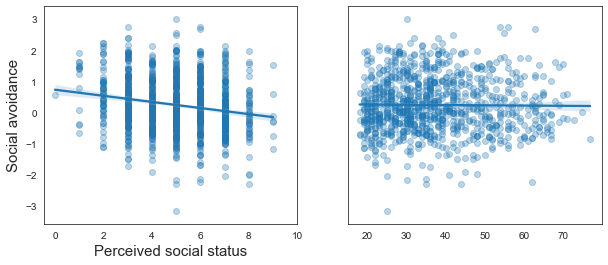

In [22]:
fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)
sns.regplot(all_df['demo_ladder_rate'], all_df['factor_social'], 
            scatter_kws={'alpha':0.3},
            ax=axs[0])
axs[0].set_ylabel('Social avoidance', fontsize=15)
axs[0].set_xlabel('Perceived social status', fontsize=15)
axs[0].set_xticks([0,2,4,6,8,10])

sns.regplot(all_df['demo_age'], all_df['factor_social'], 
            scatter_kws={'alpha':0.3},
            ax=axs[1])
axs[1].set_ylabel('')
axs[1].set_xlabel('', fontsize=15)
# axs[1].set_xticks([0,2,4,6,8,10])
plt.show()


In [23]:
scipy.stats.kendalltau(all_df['demo_age'], all_df['demo_ladder_rate'])

KendalltauResult(correlation=-0.006504276199592184, pvalue=0.7786632883239148)

## Check for confounds

### Demographics
No obvious relationships to gender or age or perceived social status

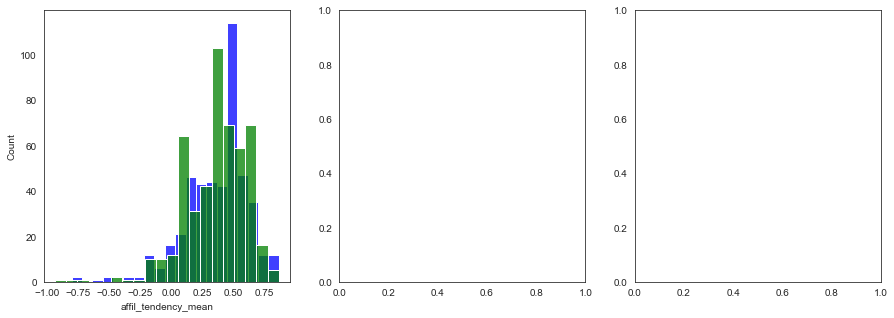

In [11]:
m = all_df['demo_gender_1W'] == 2
w = all_df['demo_gender_1W'] == 1

wh = all_df['demo_race_white'] == 1
nwh = all_df['demo_race_white'] == 0

f, axs = plt.subplots(1,3, figsize=(15,5))
sns.histplot(all_df['affil_tendency_mean'][m], color='blue', bins=20, ax=axs[0], label='men')
sns.histplot(all_df['affil_tendency_mean'][w], color='green', bins=20, ax=axs[0], label='women')
plt.show()

In [ ]:
# m = df['demo_gender_1W'] == 2
# w = df['demo_gender_1W'] == 1

# f, axs = plt.subplots(1,3, figsize=(10,5))
# sns.histplot(df['affil.tendency.mean'][m], color='blue', bins=20, ax=axs[0], label='men')
# sns.histplot(df['affil.tendency.mean'][w], color='green', bins=20, ax=axs[0], label='women')

# sns.histplot(df['power.tendency.mean'][m], color='blue', bins=20, ax=axs[1], label='men')
# sns.histplot(df['power.tendency.mean'][w], color='green', bins=20, ax=axs[1], label='women')

# sns.histplot(df['affil-power.tendency.mean'][m], color='blue', bins=20, ax=axs[2], label='men')
# sns.histplot(df['affil-power.tendency.mean'][w], color='green', bins=20, ax=axs[2], label='women')

# plt.legend(loc='upper right') #, frameon=False)
# plt.suptitle('Gender')
# plt.show()


# w = df['demo_race_white'] == 1
# nw = df['demo_race_white'] == 0

# f, axs = plt.subplots(1,3, figsize=(10,5))
# sns.histplot(df['affil.tendency.mean'][w], color='blue', bins=20, ax=axs[0], label='white')
# sns.histplot(df['affil.tendency.mean'][nw], color='green', bins=20, ax=axs[0], label='nonwhite')

# sns.histplot(df['power.tendency.mean'][w], color='blue', bins=20, ax=axs[1], label='white')
# sns.histplot(df['power.tendency.mean'][nw], color='green', bins=20, ax=axs[1], label='nonwhite')

# sns.histplot(df['affil-power.tendency.mean'][w], color='blue', bins=20, ax=axs[2], label='white')
# sns.histplot(df['affil-power.tendency.mean'][nw], color='green', bins=20, ax=axs[2], label='nonwhite')

# plt.legend(loc='upper right') #, frameon=False)
# plt.suptitle('Race')
# plt.show()

# sns.regplot(y=df['affil.tendency.mean'], x=df['demo_age'], color='blue', label='affil')
# sns.regplot(y=df['power.tendency.mean'], x=df['demo_age'], color='red', label='power')
# sns.regplot(y=df['affil-power.tendency.mean'], x=df['demo_age'], color='purple', label='affil-power')
# plt.legend(loc='upper right')
# plt.ylabel('Tendency')
# plt.title('Age')
# plt.show()

# sns.regplot(y=df['affil.tendency.mean'], x=df['demo_ladder_rate'], color='blue', label='affil')
# sns.regplot(y=df['power.tendency.mean'], x=df['demo_ladder_rate'], color='red', label='power')
# sns.regplot(y=df['affil-power.tendency.mean'], x=df['demo_ladder_rate'], color='purple', label='affil-power')
# plt.legend(loc='upper right')
# plt.ylabel('Tendency')
# plt.title('Percexived social status')
# plt.show()

### Culture
No obvious relationship to tight/loose culture or political party

In [ ]:
# # 1, Democrat
# # 2, Republican
# # 3, Independent (lean Democrat)
# # 4, Independent (lean Republican)
# # 5, Independent (no lean)

# d = (df['polit_party'] == 1) | (df['polit_party'] == 3)
# r = (df['polit_party'] == 2) | (df['polit_party'] == 4)

# f, axs = plt.subplots(1,3, figsize=(10,5))
# sns.histplot(df['affil.tendency.mean'][d], color='blue', bins=20, ax=axs[0], label='Dem')
# sns.histplot(df['affil.tendency.mean'][r], color='red', bins=20, ax=axs[0], label='Rep')

# sns.histplot(df['power.tendency.mean'][d], color='blue', bins=20, ax=axs[1], label='Dem')
# sns.histplot(df['power.tendency.mean'][r], color='red', bins=20, ax=axs[1], label='Rep')

# sns.histplot(df['affil-power.tendency.mean'][d], color='blue', bins=20, ax=axs[2], label='Dem')
# sns.histplot(df['affil-power.tendency.mean'][r], color='red', bins=20, ax=axs[2], label='Rep')

# plt.legend(loc='upper right') #, frameon=False)
# plt.suptitle('Political party')
# plt.show()

# sns.regplot(y=df['affil.tendency.mean'], x=df['talc_score'], color='blue', label='affil')
# sns.regplot(y=df['power.tendency.mean'], x=df['talc_score'], color='red', label='power')
# sns.regplot(y=df['affil-power.tendency.mean'], x=df['talc_score'], color='purple', label='affil-power')
# plt.title('Tight & Loose Culture')
# plt.ylabel('Tendency')
# plt.legend(loc='upper right')
# plt.show()

### Correct for a gender bias (more affiliative & give more power to female characters)
- No longer fits a simple to sell story
- But demographics is a common question - how to make sense of it?

In [ ]:
# fig, axs = plt.subplots(1,2, figsize=(8,4), sharey=True)
# for d, dim in enumerate(['affil', 'power']):

#     # get data into long
#     dims = pd.melt(df, id_vars=['sub_id'], value_vars=[dim + '.prop.by_char_0' + str(c) for c in np.arange(1,6)])
#     dims.rename(columns={'variable':'dimension','value':'tendency'}, inplace=True)

#     gender = pd.melt(df, id_vars=['sub_id'], value_vars=[char + '_gender' for char in character_roles])
#     gender.rename(columns={'variable':'character','value':'gender'}, inplace=True)
#     del gender ['sub_id']
#     gender = pd.concat([gender, gender])
#     gender.reset_index(inplace=True)

#     dim_gender = pd.concat([dims, gender], axis=1)
    
#     # plot
#     sns.barplot(x='character', y='tendency', hue='gender', data=dim_gender, ax=axs[d])
#     axs[d].set_xticklabels(labels=character_roles, rotation=60, ha='right')
#     axs[d].set_xlabel('')
#     if d == 0: 
#         axs[d].set_ylabel('proportion')
#         axs[d].legend([],[], frameon=False)
#     else:
#         axs[d].set_ylabel('')
#         sns.move_legend(axs[d], "upper left", bbox_to_anchor=(1, 1))


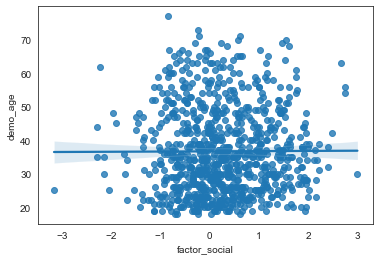

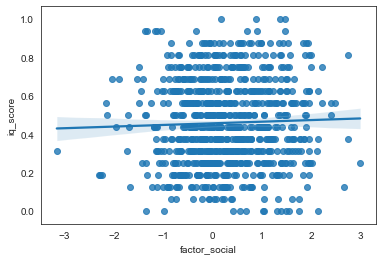

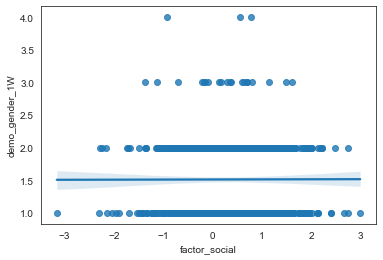

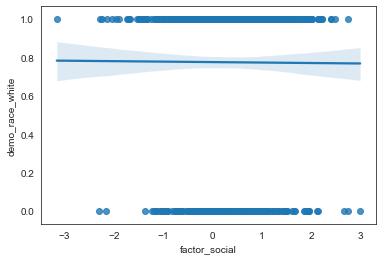

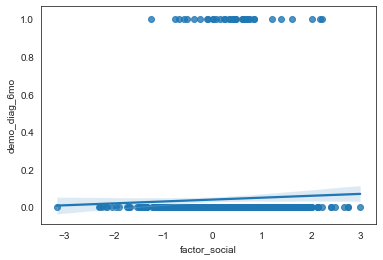

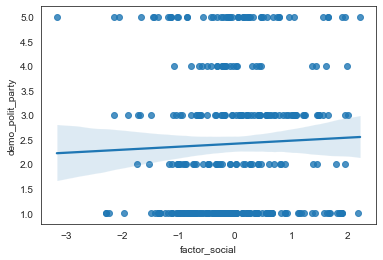

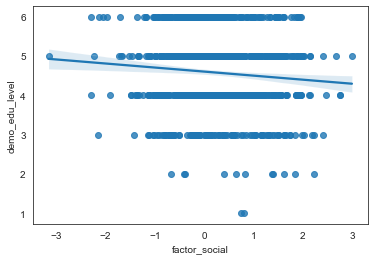

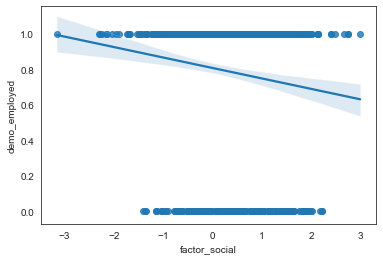

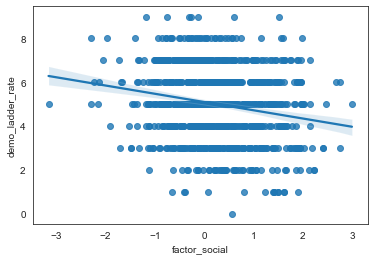

In [58]:
for demo in demo_controls + ['demo_diag_6mo', 'demo_polit_party', 'demo_edu_level', 'demo_marriage', 'demo_employed', 'demo_ladder_rate']:
    sns.regplot(x=all_df['factor_social'], y=all_df[demo])
    plt.show()

In [67]:
y = all_df['factor_social']
X = all_df[['demo_edu_level', 'demo_employed', 'demo_diag_6mo', 'demo_marriage', 'demo_ladder_rate'] + demo_controls]
X = sm.add_constant(X)
model = sm.OLS(y, X, missing='drop')
results = model.fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          factor_social   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     4.579
Date:                Sun, 17 Jul 2022   Prob (F-statistic):           6.55e-06
Time:                        13:43:36   Log-Likelihood:                -1022.0
No. Observations:                 804   AIC:                             2064.
Df Residuals:                     794   BIC:                             2111.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.7512      0.200      3.759      0.000       0.359       1.143
demo_edu_level      -0.0042      0.036     -0.118      0.906      -0.074       0.066
demo_employed       -0.1495      0.080     -1.865      0.063      -0.307       0.008
demo_diag_6mo        0.0490      0.166      0.296      0.767      -0.276       0.374
demo_marriage        0.0723      0.069      1.040      0.298      -0.064       0.209
demo_ladder_rate    -0.0981      0.020     -4.791      0.000      -0.138      -0.058
demo_age             0.0010      0.003      0.382      0.702      -0.004       0.006
iq_score             0.2015      0.142      1.422      0.156      -0.077       0.480
demo_gender_1W      -0.0126      0.055     -0.228      0.820      -0.121       0.096
demo_race_white      0.0168      0.076      0.221      0.825      -0.133       0.166
==============================================================================
Omnibus:                        2.232   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.328   Jarque-Bera (JB):                2.162
Skew:                           0.067   Prob(JB):                        0.339
Kurtosis:                       3.216   Cond. No.                         266.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
[c for c in all_df.columns if 'demo' in c]

['demo_age',
 'demo_sex_1F',
 'demo_gender_1W',
 'demo_race_amer_indian_or_alaska_native',
 'demo_race_asian',
 'demo_race_black/aa',
 'demo_race_latino/hispanic',
 'demo_race_multiracial',
 'demo_race_nat_hawaiian_or_pac_isl',
 'demo_race_white',
 'demo_race_other',
 'demo_race_other_text',
 'demo_marriage',
 'demo_handedness_1R',
 'demo_edu_level',
 'demo_occupation',
 'demo_ladder_rate',
 'demo_diag_6mo',
 'demo_adjust',
 'demo_adhd',
 'demo_autism',
 'demo_bipolar',
 'demo_avpd',
 'demo_bpd',
 'demo_mdd',
 'demo_ed',
 'demo_gad',
 'demo_ocd',
 'demo_ld',
 'demo_panic',
 'demo_gambling',
 'demo_ptsd',
 'demo_scz',
 'demo_spd',
 'demo_sad',
 'demo_tourettes',
 'demo_sud',
 'demo_other_disorder',
 'demo_sud_specified',
 'demo_psych_med_current',
 'demo_psych_med_specified',
 'demo_polit_party',
 'demo_zip_code',
 'demo_occupation_other',
 'demo_social_media_1',
 'demo_social_media_fb',
 'demo_social_media_fb_freq',
 'demo_social_media_fb_friends',
 'demo_social_media_ig',
 'demo_socia